In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score

In [2]:
# ---------------------------
# CONFIG / HYPERPARAMETERS
# ---------------------------
DATA_DIR = "./dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
EPOCHS = 30
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [3]:
# ---------------------------
# DATA LOADERS
# ---------------------------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Prefetch for performance
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

Found 46564 files belonging to 2 classes.
Found 13304 files belonging to 2 classes.
Found 6653 files belonging to 2 classes.


In [4]:
# Compute class counts for class weights
def compute_class_weights(dataset):
    # dataset yields (images, labels) in batches
    counts = np.array([0,0], dtype=np.int64)
    for _, labels in dataset.unbatch().batch(1024):
        lab = labels.numpy().astype(int)
        unique, c = np.unique(lab, return_counts=True)
        for u, cnt in zip(unique, c):
            counts[u] += cnt
    # counts[0] corresponds to class 0, counts[1] to class 1
    total = counts.sum()
    # simple inverse-frequency weights
    class_weight = {0: total / (2 * counts[0]) if counts[0] > 0 else 1.0,
                    1: total / (2 * counts[1]) if counts[1] > 0 else 1.0}
    return class_weight, counts

class_weight, counts = compute_class_weights(train_ds)
print("Training class counts:", counts, "Class weights:", class_weight)

class_weight = {0: 0.7, 1: 1.3}
print("Using overridden class weights:", class_weight)

Training class counts: [25221 21343] Class weights: {0: 0.9231196225367749, 1: 1.0908494588389637}
Using overridden class weights: {0: 0.7, 1: 1.3}


In [5]:
# ---------------------------
# DATA AUGMENTATION (training only)
# ---------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),            # small rotation ~ +/- ~10 deg
    layers.RandomZoom(0.05),
    layers.RandomTranslation(0.03, 0.03),
    # brightness may be implemented as RandomContrast or a lambda
    layers.RandomContrast(0.08),
], name="data_augmentation")

In [6]:
# ---------------------------
# BUILD THE CNN (FROM SCRATCH)
# ---------------------------
def build_cnn(input_shape=(*IMG_SIZE, 3), dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)

    # Augmentation (applied only in training)
    x = data_augmentation(inputs)

    # Rescale to [0,1]
    x = layers.Rescaling(1.0 / 255.0)(x)

    # Conv blocks
    x = layers.Conv2D(32, (3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)   # binary

    model = models.Model(inputs=inputs, outputs=outputs, name="cnn_scratch")
    return model

model = build_cnn()
model.summary()

Model: "cnn_scratch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      

In [7]:
# ---------------------------
# COMPILE
# ---------------------------
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
)

In [8]:
# ---------------------------
# CALLBACKS
# ---------------------------
checkpoint_path = os.path.join(MODEL_DIR, "best_cnn.h5")
cb_checkpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
cb_early = callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=6, restore_best_weights=True, verbose=1)
cb_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)

# ---------------------------
# TRAIN
# ---------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[cb_checkpoint, cb_early, cb_reduce]
)

# Save final model
model.save(os.path.join(MODEL_DIR, "cnn_final.h5"))

Epoch 1/30
1456/1456 [==============================] - 198s 117ms/step - loss: 0.6755 - accuracy: 0.4823 - precision: 0.4644 - recall: 0.8439 - auc: 0.5257 - val_loss: 0.6844 - val_accuracy: 0.6026 - val_precision: 0.5664 - val_recall: 0.5674 - val_auc: 0.6657

Epoch 00001: val_auc improved from -inf to 0.66565, saving model to models\best_cnn.h5
Epoch 2/30
1456/1456 [==============================] - 169s 116ms/step - loss: 0.6330 - accuracy: 0.5126 - precision: 0.4831 - recall: 0.9047 - auc: 0.6123 - val_loss: 0.6638 - val_accuracy: 0.5615 - val_precision: 0.6148 - val_recall: 0.1159 - val_auc: 0.6995

Epoch 00002: val_auc improved from 0.66565 to 0.69952, saving model to models\best_cnn.h5
Epoch 3/30
1456/1456 [==============================] - 170s 116ms/step - loss: 0.5699 - accuracy: 0.6227 - precision: 0.5586 - recall: 0.8429 - auc: 0.7326 - val_loss: 0.7173 - val_accuracy: 0.6379 - val_precision: 0.9871 - val_recall: 0.2129 - val_auc: 0.7784

Epoch 00003: val_auc improved from

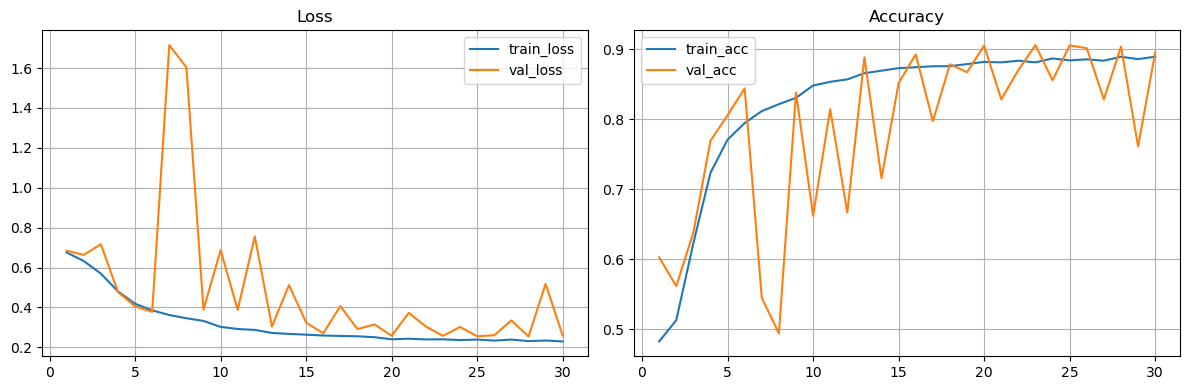

In [9]:
# ---------------------------
# PLOTS: Training Curves
# ---------------------------
def plot_training_history(history, out_path="training_curves.png"):
    hist = history.history
    epochs_range = range(1, len(hist['loss']) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, hist['loss'], label='train_loss')
    plt.plot(epochs_range, hist['val_loss'], label='val_loss')
    plt.legend(); plt.title('Loss'); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(epochs_range, hist['accuracy'], label='train_acc')
    plt.plot(epochs_range, hist['val_accuracy'], label='val_acc')
    plt.legend(); plt.title('Accuracy'); plt.grid(True)

    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()

plot_training_history(history, out_path=os.path.join(MODEL_DIR, "training_curves.png"))


Test set results:
              precision    recall  f1-score   support

         0.0     0.9347    0.8698    0.9011      3603
         1.0     0.8579    0.9282    0.8917      3050

    accuracy                         0.8966      6653
   macro avg     0.8963    0.8990    0.8964      6653
weighted avg     0.8995    0.8966    0.8968      6653

Confusion Matrix:
 [[3134  469]
 [ 219 2831]]
ROC AUC: 0.9712
F1 score: 0.8917


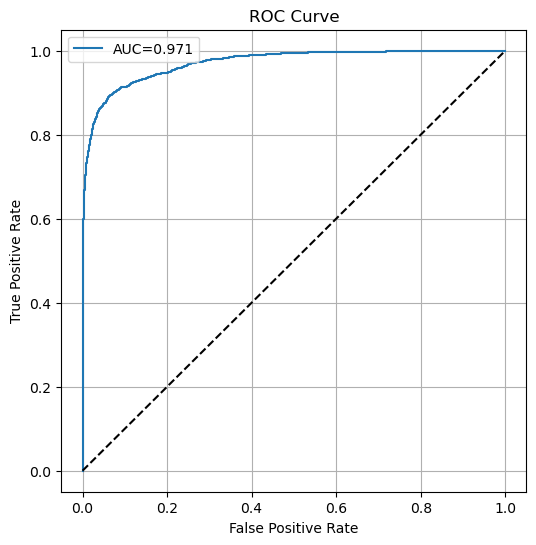


Done. Best model saved to: models\best_cnn.h5


In [10]:
# ---------------------------
# EVALUATE ON TEST SET
# ---------------------------
# Gather predictions and true labels
y_true = []
y_pred_prob = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0).ravel()
    y_pred_prob.extend(probs.tolist())
    y_true.extend(labels.numpy().tolist())

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Metrics
print("\nTest set results:")
print(classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
auc = roc_auc_score(y_true, y_pred_prob)
print("ROC AUC: {:.4f}".format(auc))
f1 = f1_score(y_true, y_pred)
print("F1 score: {:.4f}".format(f1))

# Plot ROC
fpr, tpr, th = roc_curve(y_true, y_pred_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Save test predictions for later analysis
np.savez(os.path.join(MODEL_DIR, "test_predictions.npz"),
         y_true=y_true, y_pred=y_pred, y_pred_prob=y_pred_prob)

print("\nDone. Best model saved to:", checkpoint_path)